# Sentencias Estructurales

In [1]:
%%capture --no-display
%load_ext autoreload
%autoreload 2
from reporte import *
from IPython.display import Latex

# Inicialización y Carga de datos
spark, sc = init_spark()
estructurales = cargar_datos(spark)

21/10/05 20:43:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/05 20:43:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Introducción

En este reporte se exploran resultados preliminares de la aplicación de los criterios de clasificación de sentencias estructurales en el corpus de resoluciones de la Sala Constitucional de Costa Rica. Estos criterios están definidos en el documento de trabajo _"Propuesta de definición y operacionalización de sentencias estructurales"_ (Estado de la Justicia, 2021), donde se agrupan las tres dimensiones Contenido, Forma y Calidad:

### Dimensión Contenido
 
 
| Num. | Característica                                                                | Operacionalización               | Unidad de registro                               |
| ---- |:------------------------------------------------------------------------------|:----------------------------------|:--------------------------------------------------|
| CO01  | Busca solucionar un problema estructural, reiterado y serio                   | Problema estructural que atiende | Listado de problemas estructurales a identificar |
| CO02  | Se centra en la protección de temáticas relacionados con los derechos humanos | 1. Se menciona un derecho humano afectado? <br> 2. Cuál? | 1. Sí y no.  <br> 2. Listado de derechos humanos a identificar |
| CO03  | Afecta a un grupo de personas, más allá de quién (es) presentaron el recurso | 1. En la sección general hay más de un demandante (un nombre). <br> 2. Por lo tanto menciona un grupo de la población específico | 1. Sí o no.  | Contien la palabra indígenas, personas con discapacidad, privados de libertad, vecinos, estudiantes, pacientes, etc. |
| CO04  | Sirve como referente en la resolución de un elevado número de casos similares o idénticos |  1. Es citado en otras resoluciones. <br> 2. ¿Cuáles? | 1.Número de veces que se cita en otras resoluciones. <br> 2.Expedientes en los cuales se cita. |
| ~~CO05~~  | Establece como una condición dar seguimiento para verificar el cumplimiento efectivo de dicha sentencia | Contiene la palabra "Seguimiento" | 1. Sí o no. <br> 2. (Informes??, planificación??) |
 
 

### Dimensión Forma

| Num. | Característica  | Operacionalización | Unidad de registro   |
| ---- |:----------------|--------------------|----------------------|
| FO01 | Implica órdenes/disposiciones de cumplimiento obligatorio  | Contiene un "Se ordena" <br> (?? Con un plazo)  | Sí o no.   |
| FO02 | Señala qué debe hacerse y a quién (persona o ente) le corresponde realizar dicha acción  | Después de la palabra “se ordena” se menciona un nombre de la persona o institución  | Extraer el nombre completo.   |
| FO03 | Define plazos para el cumplimiento de las órdenes/disposiciones emitidas  | En el Por Tanto se menciona la palabra “meses”  | Extraer las palabras o números antes de meses.   |
| FO04 | Se registran declaraciones/pronunciamientos repetidos por parte de la Sala Constitucional  | Cantidad de referencia a otras sentencias similares o iguales  | Número de referencias <br> Número de expediente de las sentencias a las cuales se hace referencia  |
| FO05 | Señala que para el cumplimiento del problema estructural se debe elaborar un plan  | Aparece la palabra “plan”  | Sí o no  |
| FO06 | Hay más de una institución involucrada en la ejecución y supervisión del cumplimiento de la sentencias  | ¿Cuántas instituciones están involucradas en la ejecución y supervisión del cumplimiento de la sentencias?  | Sí o no <br> Número de instituciones  |

### Dimensión Calidad
| Característica   | Operacionalización | Unidad de registro   |
|:-----------------|--------------------|----------------------|
| Extensión de la sentencia  | Cantidad de palabras (entre X y Y)  | Números absolutos  |
| Tiempo que tomó emitir la resolución  | Meses que tomó emitir la resolución (entre X y Y)  | Fecha de presentación del recurso y fecha del voto  |
| Uso de lenguaje jurídico y técnico  | Cantidad de términos jurídicos y técnicos únicos citados  | Términos únicos en el texto.  |
| Profundidad de las argumentaciones expuestas  |    |   |
| Cantidad de fuentes/autores citados  | En el Considerando: se mencionan autores, líneas filosóficas o literatura   | Incluye las palabras doctrina, literatura,  |
| Jurisprudencia citada  | En el Considerando se citan instrumentos internacionales referidos, u organismos internacionales, incluyendo cortes internacionales, otros tribunales constitucionales  | Cantidad de instrumentos. <br> <br>Listado de instrumentos citados. <br> <br>Listado de organizaciones citadas  |
| Redactada por los magistrados y magistradas propietarios  | Redacta un propietario. <br> <br> <br>Votación la realizan  magistrados (as) propietarios (as)   | Si o no.  <br> <br>Cantidad de magistrados (as) propietarios (as) que votan  |

# Dimensión Contenido

## Criterio CO5. Seguimiento

In [9]:
seguimiento_total = estructurales.seleccion.sdf.where('seguimiento != 0').count()

Latex(f'''
El objetivo es identificar si en el portanto de la sentencia se hace referencia
a alguna estrategia de seguimiento, ya sea por la misma Sala o por un tercero.


Para obtener la información, se realiza una búsqueda de la palabra seguimiento
en el portanto pero no se obtienen resultados concluyentes: solo se obtienen
{seguimiento_total} sentencias con la palabra, pero la mayor parte no hacen
referencia a un plan de seguimiento en particular.

''')

<IPython.core.display.Latex object>

# Dimensión Forma

## FO01. Se ordena

In [12]:
se_ordena_total = (estructurales
                    .seleccion.sdf
                    .where('se_ordena != 0')
                    .count())


con_lugar_total = (estructurales
                     .seleccion.sdf
                     .where('termino_ext == "Con lugar" OR  termino_ext == "Con lugar parcial" ')
                     .count())

porcentaje_seordena = 100*se_ordena_total/con_lugar_total

En las sentencias "con lugar", normalmente se le ordena a los recurridos alguna acción relacionada a la naturaleza de la sentencia. Esta orden se da a personas particulares, en puestos públicos o pertenecientes a alguna institución o entidad. 

In [13]:
Latex(f'''
Del total de sentencias _"con lugar"_ o _"con lugar parcial"_, el {porcentaje_seordena:1.2f}%, manteniendo un comportamiento homgéneo durante todos los años (Figura 1).
''')

<IPython.core.display.Latex object>

<AxesSubplot:title={'center':"Sentencias 'Con lugar' con los términos 'Se ordena'"}, xlabel='Año', ylabel='Cantidad'>

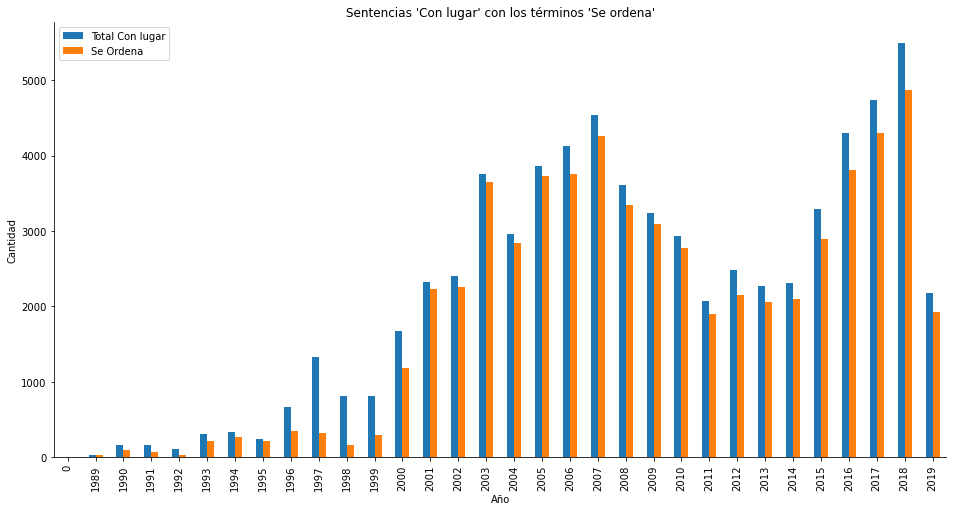

In [4]:
grafico_se_ordena_anno(estructurales)

## FO02. Se señala qué debe hacerse y a quién

Instituciones que aparecen en se ordena

Plazo en el cumplimiento de la orden

## Gráficos

In [6]:
from pyspark.sql.functions import explode, desc
from pyspark.sql import functions as F
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


df2 = (estructurales.seleccion.sdf
 .where(estructurales.seleccion.sdf.se_ordena_LOC.isNotNull())
 .select(explode('se_ordena_LOC').alias('se_ordena_LOC'), 'anno')
 .groupby('se_ordena_LOC')
 .count()
 .sort(F.desc('count'))
).toPandas()
df2

,se_ordena_LOC,count
0,Ministerio de Educación Pública,7252
1,Sala,2558
2,Ministerio Público,2095
3,Hospital Dr. Rafael Ángel Calderón Guardia,1684
4,Zona de Menor Desarrollo,1367
5,Alajuela,1119
6,Ministro de Educación Pública,1105
7,Hospital San Rafael de,992
8,Hospital San Juan de Dios,798
9,la Ley,643


In [16]:
from nlppen.spacy_entities import nlp_test
from tqdm.auto import tqdm

df2 = (estructurales
 .seleccion.sdf
 .where(estructurales.seleccion.sdf.se_ordena_ORG.isNotNull())
 .select(explode('se_ordena_ORG').alias('se_ordena_ORG'), 'anno')
 .groupby('se_ordena_ORG')
 .count()
 .sort(F.desc('count'))
).toPandas()


def publica(txt):
    doc = nlp_test(txt)
    return [{'lbl':ent.ent_id_, 'text': ent.text} for ent in doc.ents if ent.label_ == "Entidad Pública"]

tqdm.pandas()
df2['EntidadPublica'] = df2.se_ordena_ORG.progress_apply(publica)

In [18]:
estructurales.seleccion.sdf.columns

['archivo',
 'txt',
 'cleanText',
 'num',
 'fechahora_ext',
 'redactor_ext',
 'tipoResolucion_ext',
 'termino_ext',
 'voto_salvado',
 'tema',
 'Recurrente_ents',
 'Cantón_ents',
 'Fecha_ents',
 'Constitución_ents',
 'Redactor_ents',
 'Ley_ents',
 'EntidadPublica_ents',
 'tema_prob',
 'termino_lst',
 'expediente',
 'Fechahora_ents',
 'CitaSentencias_ents',
 'Recurrido_ents',
 'Reglamento_ents',
 'Magistrado_ents',
 '_id',
 'anno',
 'seguimiento',
 'se_ordena',
 'plan',
 'plazo',
 'se_ordena_PER',
 'se_ordena_LOC',
 'se_ordena_ORG',
 'se_ordena_MISC',
 'se_ordena_GPE',
 'extension_sentencia',
 'extension_por_lo_tanto',
 'plazosDefinidos']